In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sgcc_model12 import *

### The problem: 
- The optimizer finds multiple degenerate solutions due to permutation symmetries in the dLGN units connected to each V1 unit.
- Because of this, final dLGN parameter distributions are not identifiable.

### The solution:
- Apply identifiability constraints to dLGN units such that for each set of dLGN units connected to a V1 units:
    - dLGN_1 <= dLGN_2 <= dLGN_3

### The steps:
- Draw a set of random dLGN parameter values from a normal distribution with $\mu$=0 and $\sigma$=1. These are the only values to which the gradients will be applied. The shape of this tensor is: (n_samples, n_v1, n_dlgn, n_param, 1, 1).
- Set first dlgn unit (n_samples, n_v1, n_dlgn = 0, n_param, 1, 1) as the leading unit. This unit will have the lowest possible value for its corresponding parameter. For example, this value could be [1].
- Set the values of the proceeding dLGN units (n_samples, n_v1, n_dlgn = 1:, n_param, 1, 1) as the trailing offsets. For example, these values could be [1,1].
- Get the cumulative sum of the trailing offsets, for the above example this would be be [1,2]. This will ensure that the value of each consecutive n_lgn unit is greater than the last.
- Add the cumulative sum of the trailing offsets to the leading unit to make a new sequence called the trailing units. For the above example this would be [2,3].
- Concatenate the original leading unit with the new trailing units. For the above example, this would be [1,2,3].

### Keep in mind: 
- The reparameterization step is applied to the underlying trianable variable (dlgn_raw). 
- To load pretrained parameters, dlgn_raw must be given to load_saved_parameters(). 
- The optimizer.outputs attribute already contains dlgn_raw in 'scaled_param_history' and 'last_epoch_params'. 
- When using the set_parameter method, parameters should be given as tranformed values within their appropriate bounds.
- The set parameter will apply the following: transformed value -> reparameterized normalized -> original normalized (raw).

In [2]:
# First, set the inputs to the model: a set of spatial frequency values (in cycles per degree c/d)

X = tf.convert_to_tensor([0.02,0.04,0.08,0.1,0.12,0.16,0.2,0.24,0.28,0.32], dtype = tf.float32)

In [3]:
## We will be fitting the model to the first two PCs of the PCA transformed V1 data.

v1_xs_file = f"v1_ori_phase_condition_pcascores.pkl"
v1_scores = pd.read_pickle(os.path.join('c:\\',*os.getcwd().split('\\')[1:-1], v1_xs_file))
v1_scores_condition_averaged = np.array([np.array(x) for x in v1_scores.scores.values]).mean(0)
Y_true = v1_scores_condition_averaged[:2,:,:].transpose(0,2,1)

In [4]:
n_sample = 100
n_v1 = 2
n_lgn = 3

## Fixed parameters
T = tf.reshape(tf.cast(tf.linspace(0,250,250), dtype = DTYPE), [1, 1, 1, 1,-1])
mid = tf.cast(tf.fill([n_sample, n_v1, n_lgn, 1, 1], 0), dtype = DTYPE)

## Trainable parameters
dlgn_scaled = tf.random.normal([n_sample, n_v1, n_lgn, 5, 1, 1], mean = 0, stddev = 1)
v1_scaled = tf.random.normal([n_sample, n_v1, 1, 2, 1, 1])

dlgn_scaled = tf.Variable(dlgn_scaled, 
                                name = 'dLGN_params', 
                                trainable = True, 
                                dtype = DTYPE,
                                )

v1_scaled = tf.Variable(v1_scaled, 
                                name = 'V1_params', 
                                trainable = True, 
                                dtype = DTYPE,
                                )

In [5]:
## apply identifiability constraint (dLGN0<=dLGN1<=dLGN2)

leading_unit = dlgn_scaled[:, :, 0:1] # leading dLGN unit
trailing_offsets = tf.nn.softplus( # values added to consecutive dLGN units (enforce positive vals)
    dlgn_scaled[:, :, 1:]
) 

# get the values of the trailing units by adding the offsets to the leading unit
trailing_units = leading_unit + tf.cumsum(trailing_offsets, axis=2)
ordered_units = tf.concat([leading_unit, trailing_units], axis=2) 

In [6]:
dlgn_scaled

<tf.Variable 'dLGN_params:0' shape=(100, 2, 3, 5, 1, 1) dtype=float32, numpy=
array([[[[[[-0.08420787]],

          [[-0.16610196]],

          [[-2.0494232 ]],

          [[-0.907802  ]],

          [[ 0.4307715 ]]],


         [[[-0.86729175]],

          [[ 0.18667795]],

          [[ 0.11025526]],

          [[ 1.4888256 ]],

          [[-0.03464172]]],


         [[[-0.03324747]],

          [[ 0.8731429 ]],

          [[-0.34409583]],

          [[-1.0530232 ]],

          [[-1.0834755 ]]]],



        [[[[ 0.13464518]],

          [[-0.9838261 ]],

          [[ 0.11919827]],

          [[-0.4272767 ]],

          [[ 0.4215569 ]]],


         [[[ 0.10173961]],

          [[ 0.9654287 ]],

          [[-0.25546196]],

          [[-1.8525751 ]],

          [[ 0.9083961 ]]],


         [[[ 0.04781162]],

          [[-1.6811701 ]],

          [[-0.5728077 ]],

          [[ 0.2670056 ]],

          [[ 0.2959374 ]]]]],




       [[[[[-0.96806824]],

          [[-0.74201864]],

        

In [7]:
## invert the identifiability constraint (for loading parameters and reinitialization)

leading_unit = ordered_units[:,:,0]
trailing_offsets = ordered_units[:,:,1:] - ordered_units[:,:,:-1]
trailing_offsets = tf.math.log(tf.math.expm1(trailing_offsets)) # apply an approximate inverse softplus
x_recov = np.concatenate([leading_unit[:,:,None,:,:,:], trailing_offsets], axis = 2)

In [8]:
x_recov

array([[[[[[-0.08420787]],

          [[-0.16610196]],

          [[-2.0494232 ]],

          [[-0.907802  ]],

          [[ 0.4307715 ]]],


         [[[-0.8672916 ]],

          [[ 0.18667784]],

          [[ 0.11025518]],

          [[ 1.4888256 ]],

          [[-0.03464159]]],


         [[[-0.03324758]],

          [[ 0.8731431 ]],

          [[-0.34409583]],

          [[-1.0530233 ]],

          [[-1.0834755 ]]]],



        [[[[ 0.13464518]],

          [[-0.9838261 ]],

          [[ 0.11919827]],

          [[-0.4272767 ]],

          [[ 0.4215569 ]]],


         [[[ 0.10173968]],

          [[ 0.9654288 ]],

          [[-0.25546196]],

          [[-1.852575  ]],

          [[ 0.90839624]]],


         [[[ 0.04781167]],

          [[-1.6811702 ]],

          [[-0.5728077 ]],

          [[ 0.26700553]],

          [[ 0.29593748]]]]],




       [[[[[-0.96806824]],

          [[-0.74201864]],

          [[-0.45321378]],

          [[ 1.5107691 ]],

          [[-2.615182  ]]],




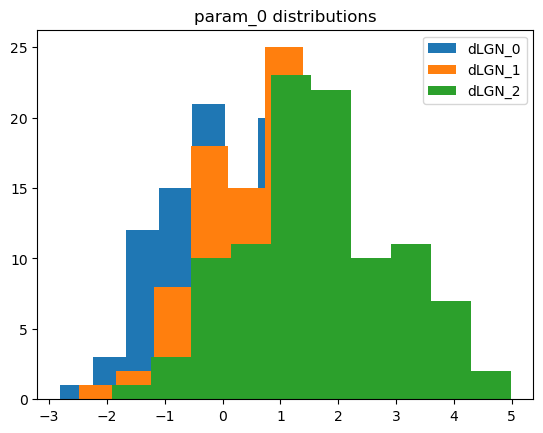

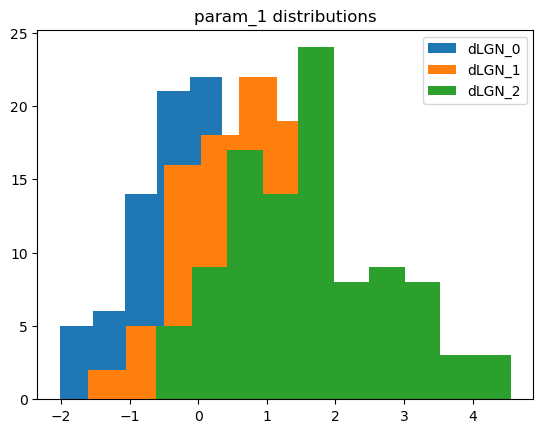

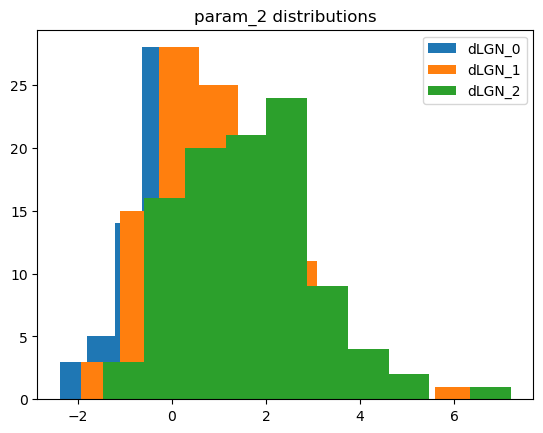

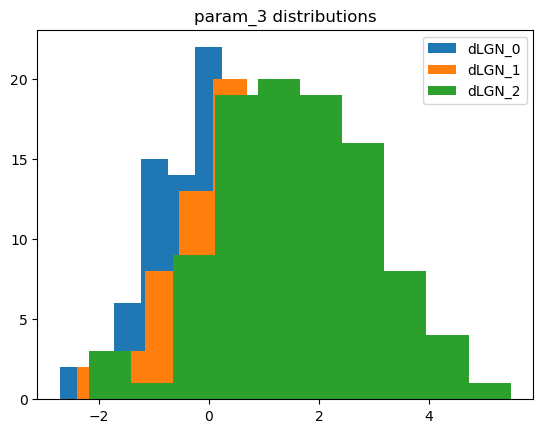

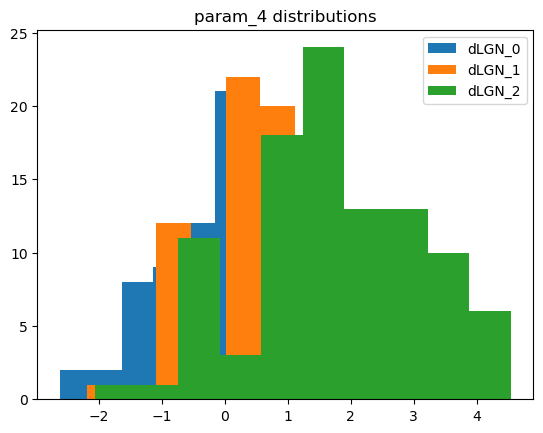

In [9]:
## sanity check

# check if values for first V1 params are ordered
for i in range(5):
    fig, ax = plt.subplots()
    for i1, dist in enumerate(ordered_units[:,0,:,i,0,0].numpy().T):
        ax.hist(dist, label = f"dLGN_{i1}")
        ax.set_title(f"param_{i} distributions")
        ax.legend()

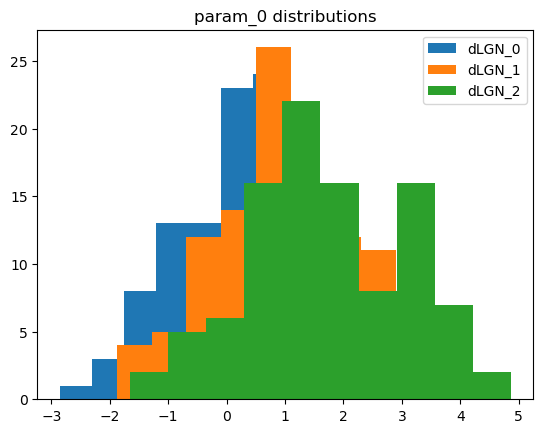

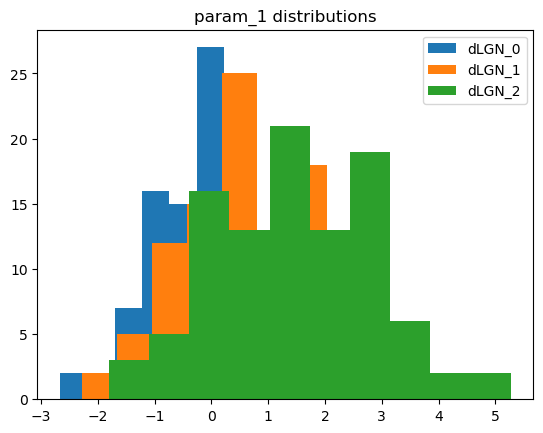

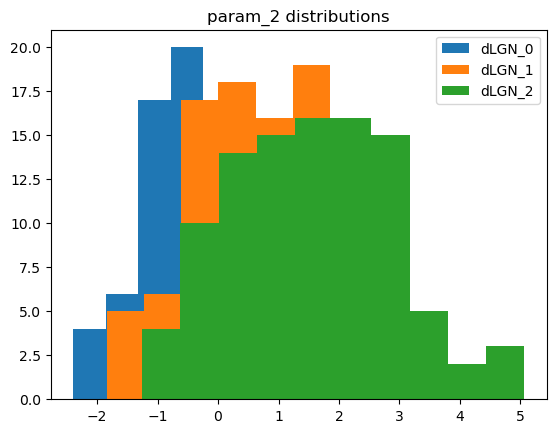

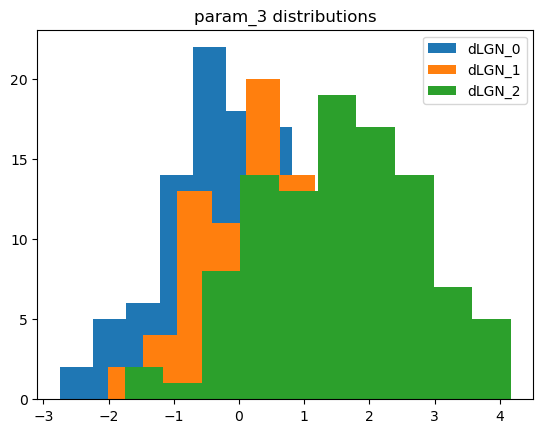

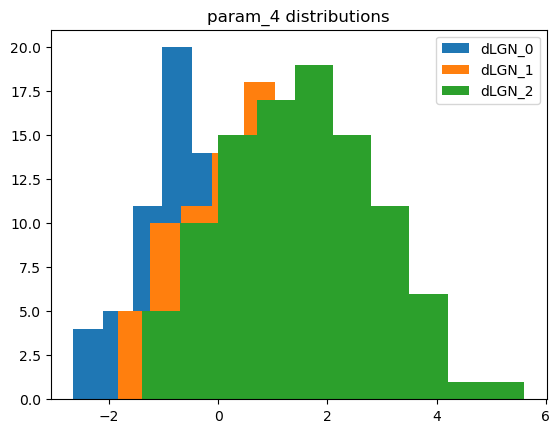

In [10]:
## sanity check

# check if values for second V1 params are ordered
for i in range(5):
    fig, ax = plt.subplots()
    for i1, dist in enumerate(ordered_units[:,1,:,i,0,0].numpy().T):
        ax.hist(dist, label = f"dLGN_{i1}")
        ax.set_title(f"param_{i} distributions")
        ax.legend()

In [11]:
## Model initialization

# set some bounds for the model parameters
param_bounds = {
    "fts": [20, 200],
    "t": [40, 100],
    "ats": [-3, 0],
    "a": [0.1, 4],
    "d": [10, 40],
    "inh_d": [0, 40],
    "inh_w": [0, 3],
}

# initialize the model
model = SGCCircuit(param_bounds)

# initialize some random starting parameters
model.initialize_random_parameters(
    n_lgn=3, # number of dLGN units
    n_v1=2, # number of V1 units
    n_sample=100 # number of exploration samples
)

In [12]:
## initialize an instance of the optimizer

optimizer = Optimize(
    model, 
    epochs=1000, # model starts fully converging around 5000 epochs, kept it low here for demonstration. 
    loss_threshold=0.11 # freeze optimization for samples that reach this loss value
)

Optimizer initialized with <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001D0ACB2FEB0>


In [ ]:
## fit the model

t0 = time.time()
loss_decay = optimizer.fit(X, Y_true)
t1 = time.time()
print(f"Ran {optimizer.epochs} optimization epochs in {round(t1-t0, 2)} sec. Average = {round((t1-t0)/(optimizer.epochs), 2)} sec/epoch.")

Training step = 0, N_exploration_samples = 100,
min_loss = 0.48565635085105896
med_loss = 5.973443984985352
max_loss = 45.15040588378906

Training step = 100, N_exploration_samples = 100,
min_loss = 0.3537841737270355
med_loss = 4.461087703704834
max_loss = 40.85553741455078

Training step = 200, N_exploration_samples = 100,
min_loss = 0.2977363169193268
med_loss = 3.369135856628418
max_loss = 36.75993347167969

Training step = 300, N_exploration_samples = 100,
min_loss = 0.26972705125808716
med_loss = 2.5974552631378174
max_loss = 32.81184768676758

Training step = 400, N_exploration_samples = 100,
min_loss = 0.2520335614681244
med_loss = 2.0190353393554688
max_loss = 29.015056610107422

Training step = 500, N_exploration_samples = 100,
min_loss = 0.23835818469524384
med_loss = 1.563246250152588
max_loss = 25.399316787719727

Training step = 600, N_exploration_samples = 100,
min_loss = 0.21592208743095398
med_loss = 1.261027216911316
max_loss = 22.007020950317383

Training step = 700,

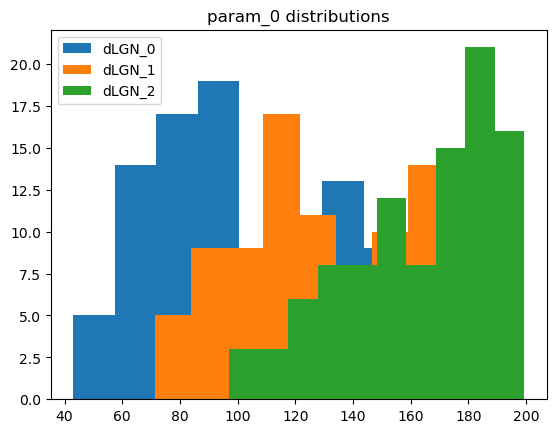

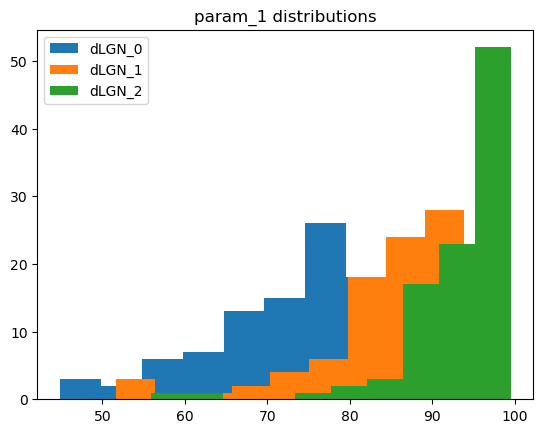

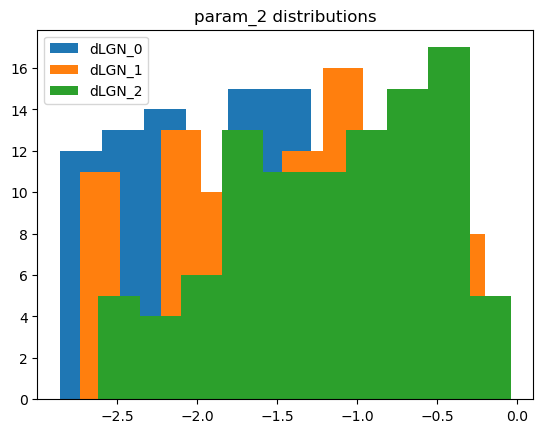

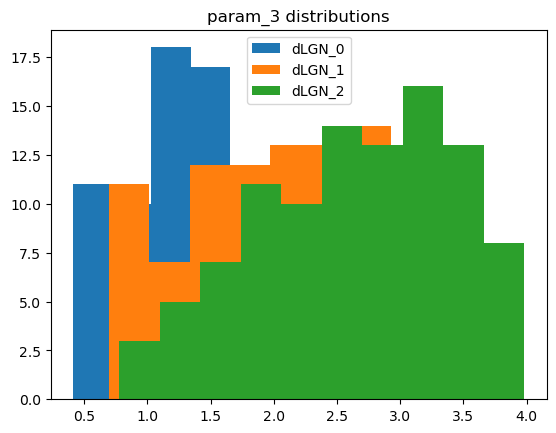

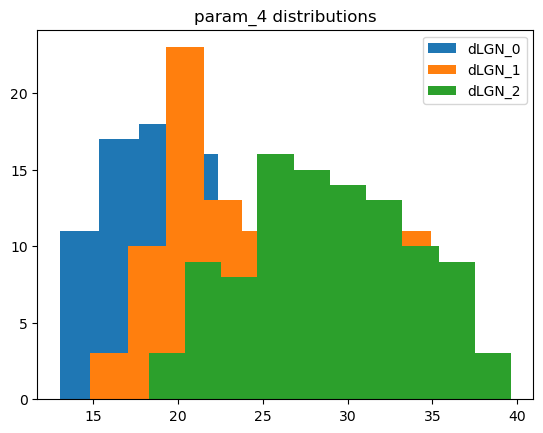

In [ ]:
## sanity check

# check if values for first V1 params are ordered
for i in range(5):
    fig, ax = plt.subplots()
    for i1, dist in enumerate(model.params['dLGN_params'][:,0,:,i,0,0].numpy().T):
        ax.hist(dist, label = f"dLGN_{i1}")
        ax.set_title(f"param_{i} distributions")
        ax.legend()

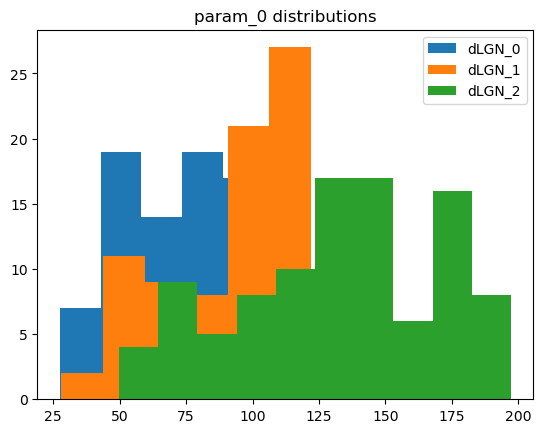

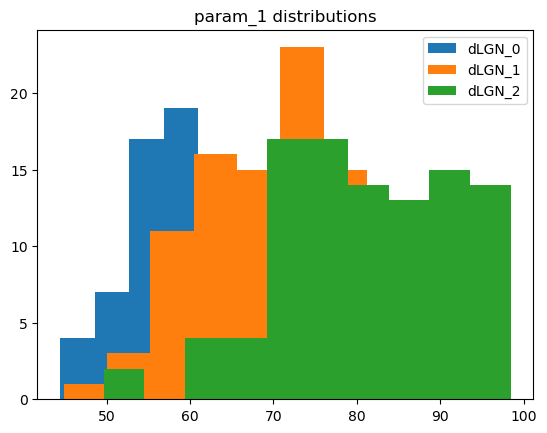

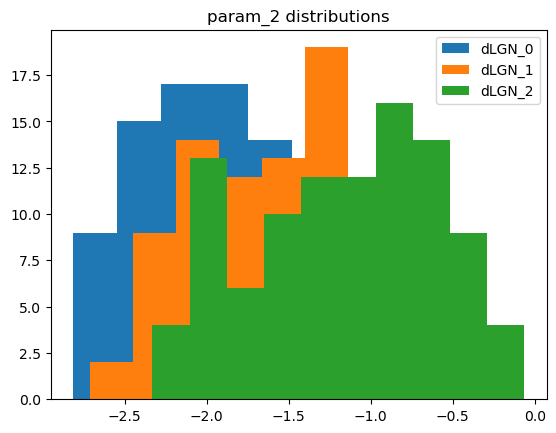

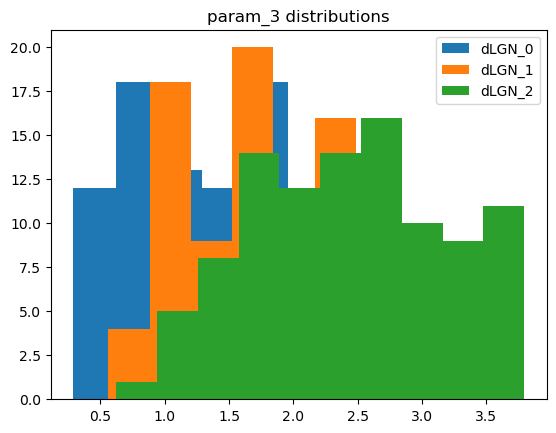

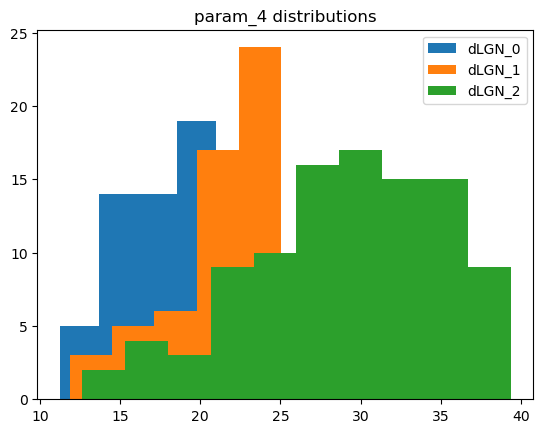

In [ ]:
## sanity check

# check if values for second V1 params are ordered
for i in range(5):
    fig, ax = plt.subplots()
    for i1, dist in enumerate(model.params['dLGN_params'][:,1,:,i,0,0].numpy().T):
        ax.hist(dist, label = f"dLGN_{i1}")
        ax.set_title(f"param_{i} distributions")
        ax.legend()

In [ ]:
# ## sanity check

# # check values for first V1 normalized params
# for i in range(5):
#     fig, ax = plt.subplots()
#     for i1, dist in enumerate(optimizer.outputs['scaled_param_history']['dLGN_params'][:,-1][:,0,:,i,0,0].T):
#         ax.hist(dist, label = f"dLGN_{i1}")
#         ax.set_title(f"param_{i} distributions")
#         ax.legend()

In [ ]:
# ## sanity check

# # check values for second V1 normalized params
# for i in range(5):
#     fig, ax = plt.subplots()
#     for i1, dist in enumerate(optimizer.outputs['scaled_param_history']['dLGN_params'][:,-1][:,1,:,i,0,0].T):
#         ax.hist(dist, label = f"dLGN_{i1}")
#         ax.set_title(f"param_{i} distributions")
#         ax.legend()

In [ ]:
## Test if a new instance can load the same model from the normalized parameters
del model
params = optimizer.outputs['final_epoch_params']

# initialize the model
model = SGCCircuit(param_bounds)
# initialize some random starting parameters
model.load_saved_parameters(params)

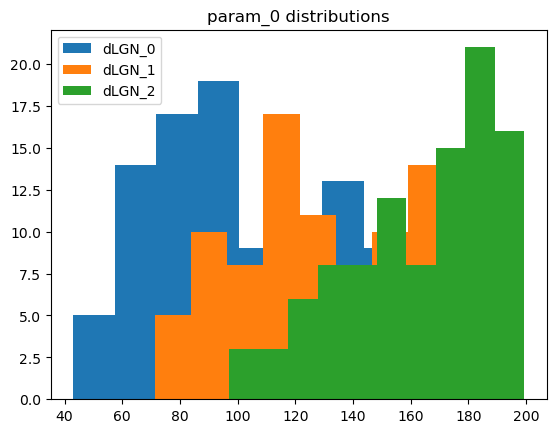

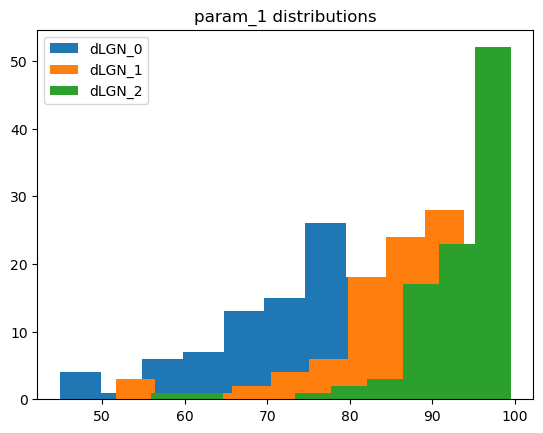

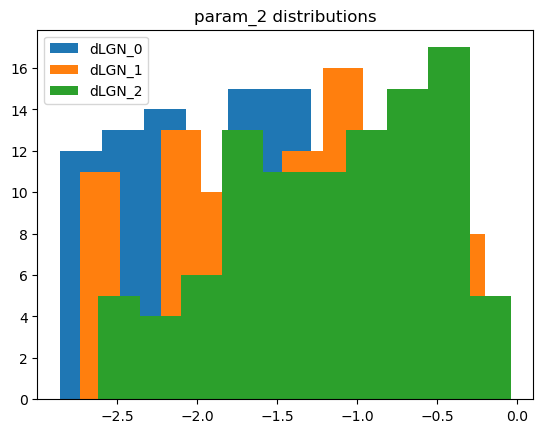

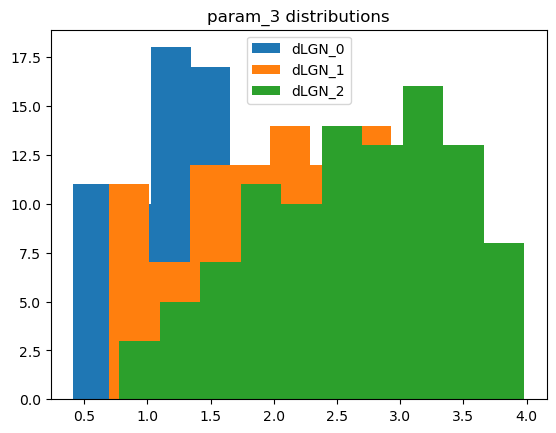

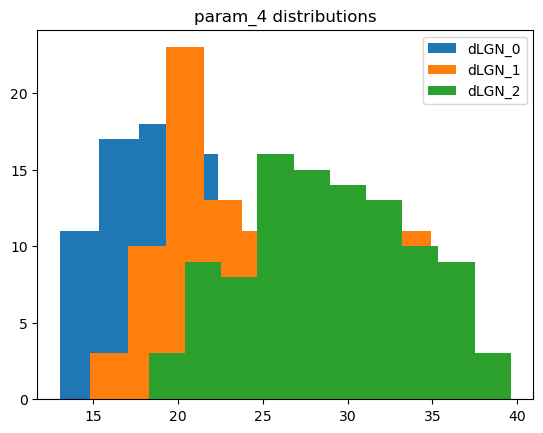

In [ ]:
## sanity check

# check if values for first V1 params are ordered
for i in range(5):
    fig, ax = plt.subplots()
    for i1, dist in enumerate(model.params['dLGN_params'][:,0,:,i,0,0].numpy().T):
        ax.hist(dist, label = f"dLGN_{i1}")
        ax.set_title(f"param_{i} distributions")
        ax.legend()